In [13]:
#limpiar base
# Eliminar todas las variables manualmente
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [14]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import ta
from ta.momentum import RSIIndicator


<Axes: xlabel='Date'>

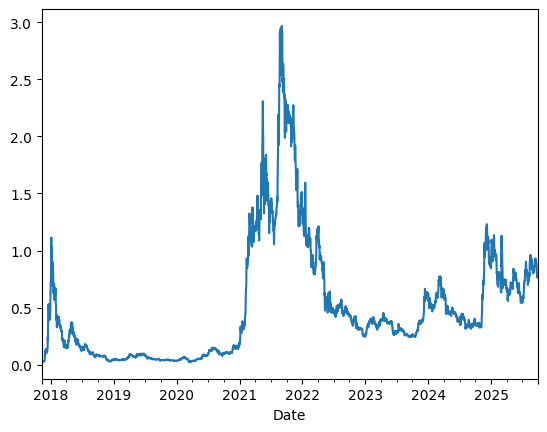

In [15]:
# taking dataset
sp500 = yf.Ticker("ADA-USD")
sp500_data = sp500.history(period="max")
# removing index of time to avoid timezone-related errors
sp500_data.index = sp500_data.index.tz_convert(None)
# Preprocessing: keep only necessary columns
sp500_data = sp500_data[['Open', 'High', 'Low', 'Close', 'Volume']]
# Generate "Tomorrow" and "Target" columns for prediction
sp500_data["Tomorrow"] = sp500_data["Close"].shift(-1)
sp500_data["Target"] = (sp500_data["Tomorrow"] > sp500_data["Close"]).astype(int)

start_date = datetime.now() - timedelta(days=30 * 365)
sp500_data_10y = sp500_data.loc[start_date:]
sp500_data_10y['Close'].plot()


In [16]:
# Calculate RSI using the ta library
sp500_data_10y["RSI"] = ta.momentum.RSIIndicator(
    close=sp500_data["Close"], window=14
).rsi()

sp500_data_10y["var"] = sp500_data_10y["RSI"].pct_change()
for n in range(3, 11):  # desde 4 hasta 10 inclusive
    sp500_data_10y[f"varacu{n}"] = sp500_data_10y["var"].rolling(window=n).sum()

for n in range(2, 11):
    sp500_data_10y[f"var{n}"] = sp500_data_10y["RSI"].diff(n)
    
sp500_data_10y["MA5_Tomorrow"] = sp500_data_10y["Tomorrow"].rolling(window=5).mean()


sp500_data_10y["Target2"] = (sp500_data_10y["MA5_Tomorrow"] > sp500_data_10y["MA5_Tomorrow"].shift(2)).astype(int)


for n in range(2, 3):  # desde 4 hasta 10 inclusive
    sp500_data_10y[f"varacuMA{n}"] = sp500_data_10y["MA5_Tomorrow"].rolling(window=n).sum()

for n in range(2, 3):
    sp500_data_10y[f"varMA{n}"] = sp500_data_10y["MA5_Tomorrow"].diff(n)

sp500_data_10y = sp500_data_10y.dropna()

C:\Users\Fernando Flores\AppData\Local\Temp\ipykernel_4912\542074399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_data_10y["RSI"] = ta.momentum.RSIIndicator(
C:\Users\Fernando Flores\AppData\Local\Temp\ipykernel_4912\542074399.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_data_10y["var"] = sp500_data_10y["RSI"].pct_change()
C:\Users\Fernando Flores\AppData\Local\Temp\ipykernel_4912\542074399.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ------------------------------
# 1. Definir variables
# ------------------------------
X = sp500_data_10y[["var","varacu3","varacu4","varacu5","varacu6","varacu7","varacu8","varacu9","varacu10",
    "var2","var3","var4","var5","var6","var7","var8","var9","var10"]]


#X = sp500_data_10y[["varacu10"]]

y = sp500_data_10y["Target2"]

# ------------------------------
# 2. Dividir train y test por tiempo (ej: 80% train, 20% test)
# ------------------------------
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ------------------------------
# 3. Modelo Random Forest
# ------------------------------
rf = RandomForestClassifier(
    n_estimators=200,       # número de árboles
    max_depth=5,           # profundidad máxima
    random_state=42
)

rf.fit(X_train, y_train)

# ------------------------------
# 4. Predicciones
# ------------------------------
y_pred = rf.predict(X_test)

# ------------------------------
# 5. Evaluación
# ------------------------------
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))
print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred))
# Obtener importancia de cada variable
importancias = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": rf.feature_importances_
})

# Ordenar de mayor a menor
importancias = importancias.sort_values(by="Importancia", ascending=False)

print(importancias)


Accuracy: 0.8881118881118881

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       321
           1       0.88      0.86      0.87       251

    accuracy                           0.89       572
   macro avg       0.89      0.88      0.89       572
weighted avg       0.89      0.89      0.89       572


Matriz de Confusión:
 [[293  28]
 [ 36 215]]
    Variable  Importancia
12      var5     0.210118
3    varacu5     0.162745
11      var4     0.142061
2    varacu4     0.129252
4    varacu6     0.061870
13      var6     0.061637
5    varacu7     0.053225
14      var7     0.030273
15      var8     0.025237
8   varacu10     0.022591
10      var3     0.020238
6    varacu8     0.018502
7    varacu9     0.012196
17     var10     0.011989
1    varacu3     0.010683
16      var9     0.010308
9       var2     0.009110
0        var     0.007966


In [18]:
# ------------------------------
# 6. Predicción del día de hoy
# ------------------------------
X_hoy = X.iloc[[-1]]  # últimos datos
prediccion_hoy = rf.predict(X_hoy)[0]

if prediccion_hoy == 1:
    print("Tendencia positiva")
else:
    print("Tendencia negativa")

Tendencia negativa
